## Imports

In [ ]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
from sympy.utilities.lambdify import lambdify
import sympy
from mpi4py import MPI
from dolfinx.io import gmshio
# import gmsh
# import dolfinx
from dolfinx import fem
import basix
import tqdm
from petsc4py import PETSc
import ufl
# import pyvista
from  dolfinx.fem import petsc
# import sys
# from dolfinx import mesh
from ufl import (
    TestFunction,
    TrialFunction,
    dx,
    inner,
)
import dolfinx
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import locate_entities_boundary, meshtags
from dolfinx import mesh as dolfinx_mesh

import numpy.typing as npt


from library.zoomy_core.fvm.solver_numpy import Settings
from library.zoomy_core.model.models.shallow_water import ShallowWaterEquations
from library.zoomy_core.mesh.mesh import Mesh
import library.zoomy_core.model.initial_conditions as IC
import library.zoomy_core.model.boundary_conditions as BC
from library.zoomy_core.misc.misc import Zstruct
import library.zoomy_core.transformation.to_ufl as trafo
import library.dg.dolfinx_solver as dg


# Transformation to UFL Code (Medium)

### Map from Sympy to UFL

In [ ]:
bcs = BC.BoundaryConditions(
    [
        # BC.Extrapolation(physical_tag="top"),
        # BC.Extrapolation(physical_tag="bottom"),
        # BC.Extrapolation(physical_tag="left"),
        # BC.Extrapolation(physical_tag="right"),
        BC.Wall(physical_tag="top"),
        BC.Wall(physical_tag="bottom"),
        BC.Wall(physical_tag="left"),
        BC.Wall(physical_tag="right"),
    ]
)

 ### Initial condition
def ic_q(x):
    R = 0.15
    r = np.sqrt((x[0] - 0.7)**2 + (x[1] - 0.7)**2)
    b = 0.1*np.sqrt((x[0] - 3.)**2 + (x[1] - 3.)**2)
    return np.array([np.where(r <= R, 1., 0.9), 0.*x[0], 0.*x[0]])

ic = IC.UserFunction(ic_q)


class SWE(ShallowWaterEquations):
    def source(self):
        out = self.chezy()
        return out   

model = SWE(
    dimension=2,
    boundary_conditions=bcs,
    initial_conditions=ic,
    parameters=Zstruct(g=9.81, C=25.),
)

settings = Settings(name="Dolfinx", output=Zstruct(directory="outputs/dolfinx", filename='dg'))


2025-10-13 11:43:52.035 | WARNING  | library.core.misc.misc:__init__:146 - No 'clean_directory' attribute found in output Zstruct. Default: False


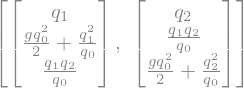

In [ ]:
model.flux()

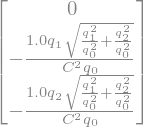

In [ ]:
model.source()

In [ ]:
solver = dg.DolfinxHyperbolicSolver(settings=settings, time_end = 1.)

In [ ]:
main_dir = os.getenv('ZOOMY_DIR')
path_to_mesh = os.path.join(main_dir, "meshes", "channel_quad_2d", "mesh_coarse.msh")
solver.solve(path_to_mesh, model)


Info    : Reading '/home/ingo/Git/Zoomy/meshes/channel_quad_2d/mesh_coarse.msh'...
Info    : 729 nodes
Info    : 816 elements
Info    : Done reading '/home/ingo/Git/Zoomy/meshes/channel_quad_2d/mesh_coarse.msh'


Setup  sim , solving PDE:  65%|██████▌   | 0.652917717182038/1.0 [00:01<00:00,  2.45s/it]   